#### Import libraries

In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings("ignore", category=Warning)

#### Import data
Source: https://www.nasdaq.com/market-activity/stocks/pho/historical

In [4]:
data = pd.read_csv("processed_data.csv")

In [5]:
data.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [6]:
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)

In [7]:
data.head()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-13,38.0143,32234.0,38.11,38.26,37.96
2019-12-14,38.0143,32234.0,38.11,38.26,37.96
2019-12-15,38.0143,32234.0,38.11,38.26,37.96
2019-12-16,38.2300,424985.0,38.24,38.35,38.16
2019-12-17,38.3300,234159.0,38.30,38.35,38.13


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2019-12-13 to 2024-12-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1827 non-null   float64
 1   Volume  1827 non-null   float64
 2   Open    1827 non-null   float64
 3   High    1827 non-null   float64
 4   Low     1827 non-null   float64
dtypes: float64(5)
memory usage: 85.6 KB


#### Date Range For Modeling

In [10]:
model_data = data["Close"].loc["2024-08-01":"2025-01-31"]

#### Test & Train Split

In [12]:
# Set training and testing sizes
train_size = int(len(model_data) * 0.95)

train, test = model_data[0:train_size], model_data[train_size:len(data)]

#### Visualizations

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

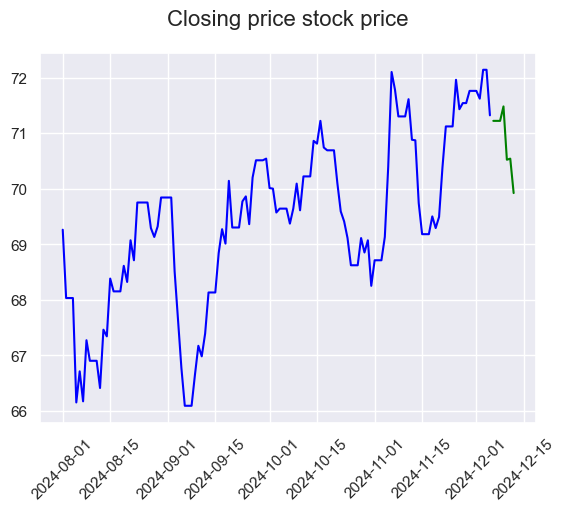

In [15]:
plt.plot(train, color="blue", label="Train Split")
plt.plot(test, color="green", label="Test Split")
plt.title("Closing price stock price", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.show()

#### ADF Test for Stationality

In [17]:
# Import Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [18]:
# ADF Test No Difference
adf_test = adfuller(train)
print(f"p-value: {adf_test[1]}")

p-value: 0.12067001146487955


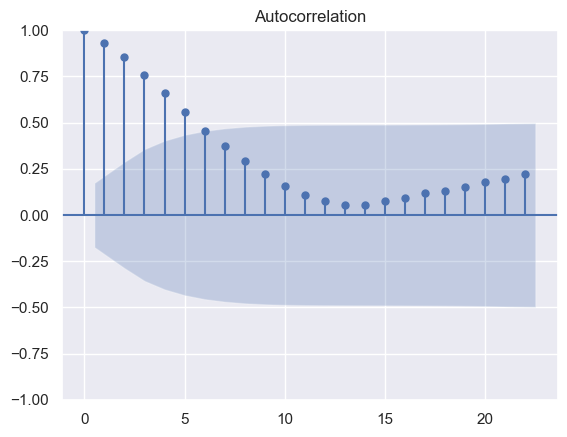

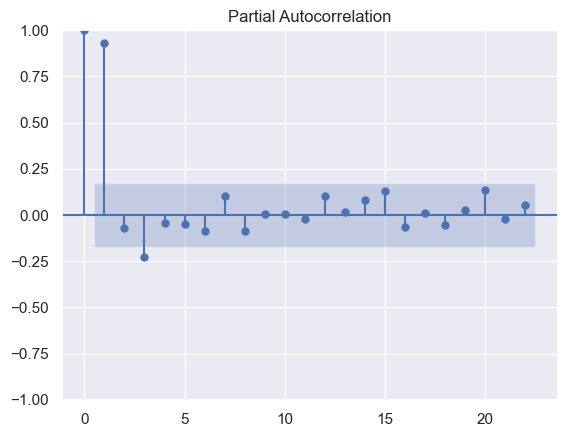

In [19]:
# Plot ACF and PCF
plot_acf(train)
plot_pacf(train)
plt.show()

<Axes: xlabel='Date'>

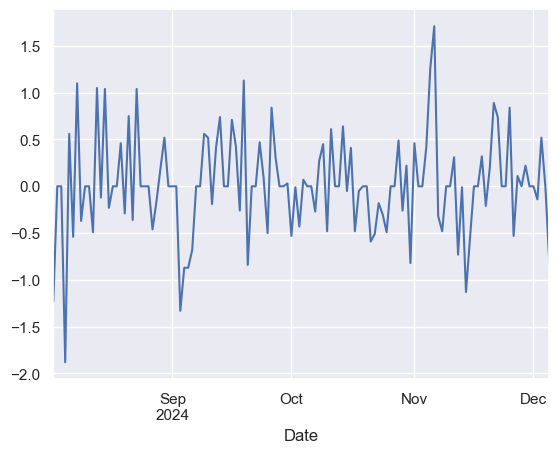

In [20]:
# ADF Test With Differencing in first order
train_df_diff = train.diff().dropna()
train_df_diff.plot()

In [21]:
# ADF Test With Differencing in first order
adf_test_diff = adfuller(train_df_diff)
print(f"p-value: {adf_test_diff[1]}")

p-value: 1.977229519027091e-08


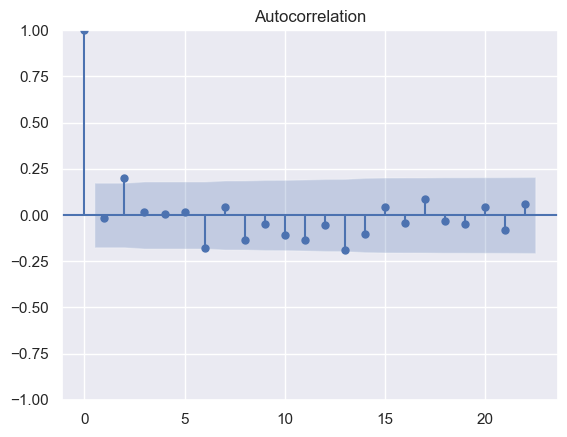

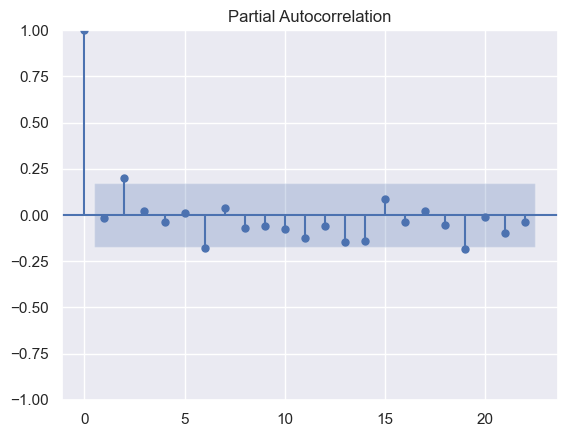

In [22]:
plot_acf(train_df_diff)
plot_pacf(train_df_diff)
plt.show()

#### Time Series Model

In [24]:
model = ARIMA(train, order=(2,1,2), freq="D")
model_fit = model.fit()
model_fit.summary()

C:\Users\jac67\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  127
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -97.804
Date:                Mon, 10 Feb 2025   AIC                            205.609
Time:                        13:01:55   BIC                            219.790
Sample:                    08-01-2024   HQIC                           211.370
                         - 12-05-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1039      0.369      0.282      0.778      -0.619       0.827
ar.L2          0.1289      0.540      0.239      0.811      -0.929       1.186
ma.L1         -0.1221      0.359     -0.340      0.734      -0.826       0.582
ma.L2          0.0877      0.535      0.164      0.870      -0.960       1.135
sigma2         0.2763      0.030      9.074      0.000       0.217       0.336
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.34
Prob(Q):                              1.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.87   Skew:                            -0.10
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Residuals Plot

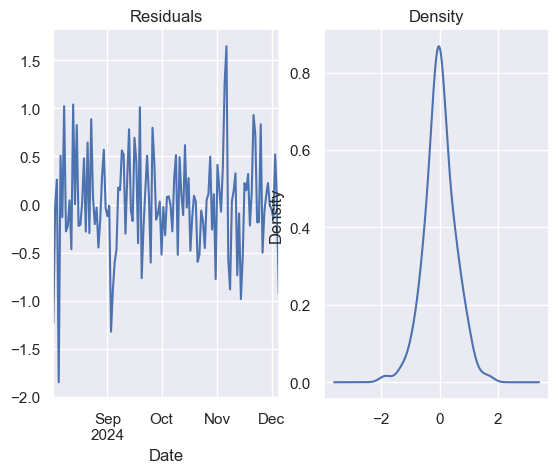

In [26]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind="kde", ax=ax[1])
plt.show()

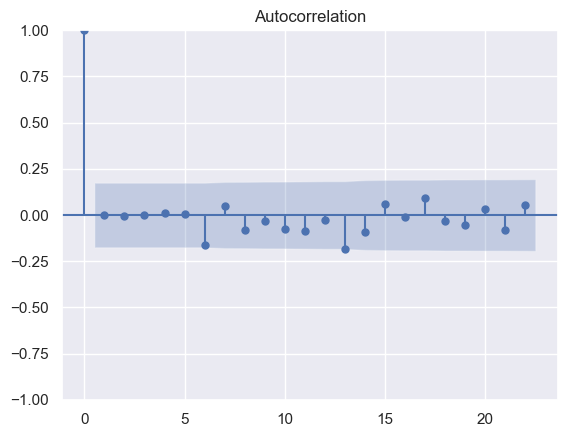

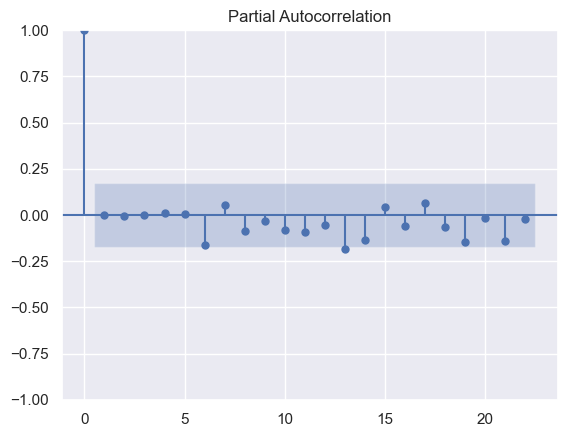

In [27]:
# ACF and PACF plots of Residuals
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

#### Forecast On Testing Data With Model

In [29]:
forecast = model_fit.forecast(steps=len(test), alpha=0.95)

In [30]:
# Compare Test Data with Forecast Data
comparison = pd.DataFrame()
comparison["Test"] = test.round(2)
comparison["Forecast"] = forecast.round(2)
comparison.head()

,Test,Forecast
Date,,
2024-12-06,71.22,71.35
2024-12-07,71.22,71.17
2024-12-08,71.22,71.15
2024-12-09,71.48,71.13
2024-12-10,70.52,71.12


#### Analyze Model Performance

In [32]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
rsme = mean_squared_error(test, forecast)

print("Mean Absolute Error =", round(mae, 3))
print("Mean Absolute Percentage Error =", round(mape, 3))
print("Mean Squared Error =", round(rsme, 3))

Mean Absolute Error = 0.426
Mean Absolute Percentage Error = 0.006
Mean Squared Error = 0.326


In [33]:
# Ratio of RSME to mean of model data inputs
ratio = rsme / np.mean(model_data)

if ratio >= 0.05:
    print("There is likely medium to high error in this model. Ratio is", f"{ratio:.1%}")
else:
    print("There is likely low error in this model, as the ratio of RSME to mean of input values is", f"{ratio:.1%}")

There is likely low error in this model, as the ratio of RSME to mean of input values is 0.5%


#### Predict Future Prices

In [35]:
predicton_steps = 60
start_index = len(train) + len(test)
end_index = start_index + predicton_steps

predictions = model_fit.predict(start = start_index, end=end_index)

In [36]:
# View last five rows of future predictions
predictions.tail(15).round(2)

2025-01-28    71.12
2025-01-29    71.12
2025-01-30    71.12
2025-01-31    71.12
2025-02-01    71.12
2025-02-02    71.12
2025-02-03    71.12
2025-02-04    71.12
2025-02-05    71.12
2025-02-06    71.12
2025-02-07    71.12
2025-02-08    71.12
2025-02-09    71.12
2025-02-10    71.12
2025-02-11    71.12
Freq: D, Name: predicted_mean, dtype: float64

#### Plot Test, Train, and Forecast

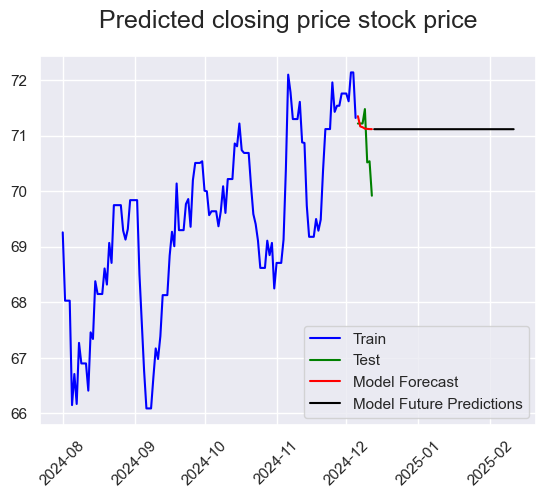

In [38]:
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(forecast, label="Model Forecast", color="red")
plt.plot(predictions, label="Model Future Predictions", color="black")
plt.title("Predicted closing price stock price", fontsize=18, pad=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()